In [1]:
import glob, json
import numpy as np
import pandas as pd
from scipy.stats import entropy
import sklearn.decomposition
import sklearn.manifold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from lib import *

In [2]:
with open('../data/triplet-human.json', 'r') as f:
    tripletparams_human = json.load(f)
    loglikelihood_human = lambda seq: loglikelihood_triplet(seq, **tripletparams_human)
with open('../data/triplet-malaria.json', 'r') as f:
    tripletparams_malaria = json.load(f)
    loglikelihood_malaria = lambda seq: loglikelihood_triplet(seq, **tripletparams_malaria)

In [3]:
k = 9
phh = np.array([loglikelihood_human(seq[i:i+k]) for h, seq in fasta_iter(human) for i in range(len(seq)-k+1) ])

In [4]:
phm = np.array([loglikelihood_malaria(seq[i:i+k]) for h, seq in fasta_iter(human) for i in range(len(seq)-k+1) ])

In [5]:
pmm = np.array([loglikelihood_malaria(seq[i:i+k]) for h, seq in fasta_iter(malaria) for i in range(len(seq)-k+1) ])

In [6]:
pmh = np.array([loglikelihood_human(seq[i:i+k]) for h, seq in fasta_iter(malaria) for i in range(len(seq)-k+1) ])

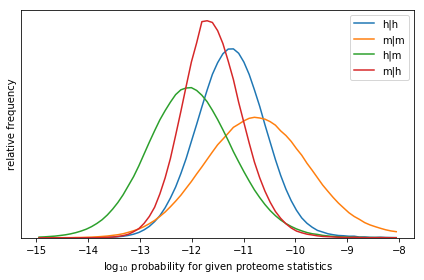

In [7]:
fig, ax = plt.subplots()
plot_histograms([phh, pmm, phm, pmh],
                ['h|h', 'm|m', 'h|m', 'm|h'],
                nbins=70,
                xmin=-15, xmax=-8, ax=ax)
ax.set_yticks([])
ax.set_ylim(0.0)
ax.set_ylabel('relative frequency')
ax.set_xlabel('$\log_{10}$ probability for given proteome statistics')
fig.tight_layout()

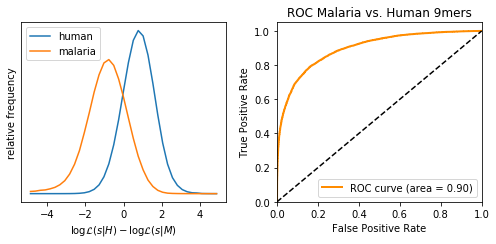

In [22]:
N = 10000
negative = (phh-phm)[np.random.randint(len(phh), size=N)]
positive = (pmh-pmm)[np.random.randint(len(pmh), size=N)]
y_true = np.concatenate([np.ones(N), np.zeros(N)])
y_score = -np.concatenate([positive, negative])
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
roc_auc = sklearn.metrics.auc(fpr, tpr)

fig, axes = plt.subplots(figsize=(7, 3.5), ncols=2)

ax = axes[0]
plot_histograms([phh-phm, pmh-pmm], ['human', 'malaria'], xmin=-5, xmax=5, ax=ax)
ax.set_xlabel('$\log \mathcal{L}(s|H) - \log \mathcal{L}(s|M)$')
ax.set_yticks([])
ax.set_ylabel('relative frequency')

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Malaria vs. Human 9mers')
plt.legend(loc="lower right")
fig.tight_layout()
fig.savefig('plots/roc-malariahuman.png', dpi=300)